## Loading molecule from QCA and calculating the MM energy with a SMIRNOFF-format forcefield

## Energy decomposition for an openmm system



In [1]:
from openforcefield.topology import Molecule, Topology
from openforcefield.typing.engines.smirnoff.forcefield import ForceField
from openforcefield.utils import get_data_file_path
from simtk import openmm, unit
import numpy as np

### Define utility function to get energy of an OpenMM system \
Force groups in openmm \
0  - 'HarmonicAngleForce' \
0 - 'HarmonicBondForce' \
11  - 'NonbondedForce'\
0  - 'PeriodicTorsionForce'

Not using the other functions forcegroupify() and getEnergyDecomposition()

In [2]:
def forcegroupify(system):
    """
    Takes in the openmm system and assigns a number label to each forcegroup, otherwise each will have zero as default
    
    Parameters
    ----------
    system : simtk.openmm.System
        The system to check
    
    Returns
    -------
    forcegroups : dict of forcegroups
    """
    forcegroups = {}
    for i in range(system.getNumForces()):
        force = system.getForce(i)
        force.setForceGroup(i)
        forcegroups[force] = i
    return forcegroups

def getEnergyDecomposition(context, forcegroups):
    """
    Takes in the openmm context and a dict of forcegroups to spit out energies under each forcegroup
    
    Parameters
    ----------
    context : simtk.openmm.context
    forcegroups : dict of forcegroups
    
    Returns
    -------
    energies : a dict of energies under each forcegroup
    """
    energies = {}
    for f, i in forcegroups.items():
        print(f, i)
        energies[f] = context.getState(getEnergy=True, groups=2**i).getPotentialEnergy()
    return energies


def get_energy(system, positions, groups):
    """
    Return the potential energy.

    Parameters
    ----------
    system : simtk.openmm.System
        The system to check
    positions : simtk.unit.Quantity of dimension (natoms,3) with units of length
        The positions to use
    groups : set of integers that represent forcegroups (setting Nonbonded as non-zero). Eg. {0, 11}
    
    Returns
    ---------
    energy : simtk.unit.Quantity
        sum of total energy
    """

    integrator = openmm.VerletIntegrator(1.0 * unit.femtoseconds)
    context = openmm.Context(system, integrator)
    context.setPositions(positions)
    for force in system.getForces():
        if force.__class__.__name__ == 'NonbondedForce':
            force.setForceGroup(11)    
#         print(force, force.getForceGroup())
    state = context.getState(getEnergy=True, groups=groups)
    energy = state.getPotentialEnergy().in_units_of(unit.kilocalorie_per_mole)
    return energy

def show_oemol_struc(oemol, torsions=False, atom_indices=[]):
    from IPython.display import Image
    from openeye import oedepict, oechem
    width = 500
    height = 300
    
    
    # Highlight element of interest
    class NoAtom(oechem.OEUnaryAtomPred):
        def __call__(self, atom):
            return False
    class AtomInTorsion(oechem.OEUnaryAtomPred):
        def __call__(self, atom):
            return atom.GetIdx() in atom_indices
    class NoBond(oechem.OEUnaryBondPred):
        def __call__(self, bond):
            return False
    class BondInTorsion(oechem.OEUnaryBondPred):
        def __call__(self, bond):
            return (bond.GetBgn().GetIdx() in atom_indices) and (bond.GetEnd().GetIdx() in atom_indices)
    class CentralBondInTorsion(oechem.OEUnaryBondPred):
        def __call__(self, bond):
            return (bond.GetBgn().GetIdx() in atom_indices[1:3]) and (bond.GetEnd().GetIdx() in atom_indices[1:3])

        
    opts = oedepict.OE2DMolDisplayOptions(
                        width, height, oedepict.OEScale_AutoScale
                    )
    opts.SetAtomPropertyFunctor(oedepict.OEDisplayAtomIdx())
    
    oedepict.OEPrepareDepiction(oemol)
    img = oedepict.OEImage(width, height)
    display = oedepict.OE2DMolDisplay(oemol, opts)
    if(torsions):
        atoms = oemol.GetAtoms(AtomInTorsion())
        bonds = oemol.GetBonds(NoBond())
        abset = oechem.OEAtomBondSet(atoms, bonds)
        oedepict.OEAddHighlighting(display, oechem.OEColor(oechem.OEYellow), oedepict.OEHighlightStyle_BallAndStick, abset)
    
    oedepict.OERenderMolecule(img, display)
    png = oedepict.OEWriteImageToString("png", img)
    return Image(png)

def show_id(num):
    import os
    import json
    sdf_filename = '/home/maverick/Desktop/OpenFF/openforcefield-forcebalance/fit0/targets/QCP-'+str(num)+'/mol.sdf'
    mol = Molecule.from_file(sdf_filename, allow_undefined_stereo=True)
    oemol = mol.to_openeye()
    with open(os.path.dirname(sdf_filename)+'/metadata.json') as json_file:
        data = json.load(json_file)
        atom_indices = data["dihedrals"][0]
    return show_oemol_struc(oemol, torsions=True, atom_indices=atom_indices)

## Load a molecule with positions, and evaluate its energy, evaluate the Nonbonded term

In this example, we load a single molecule with geometry information, parameterize it using the "Parsley" (`openff-1.3.0`) forcefield, and evaluate its energy. 



Load a molecule

SMIRNOFF Coverage Torsion Set 1


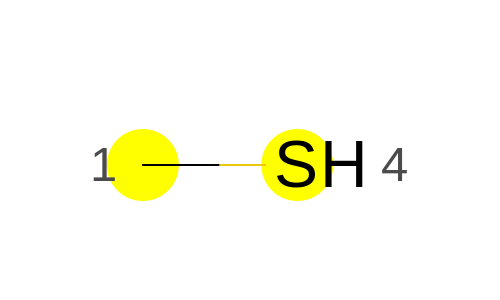

TD record: 2703045 , nonbonded energy diff: -0.0006838779781103898 kcal/mol , approx. MM barrier: 1.3561954262822815 kcal/mol , QM barrier: 1.3475109273716785


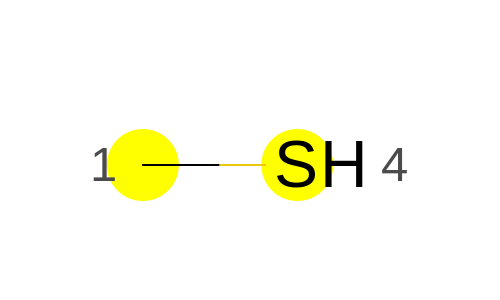

TD record: 2703046 , nonbonded energy diff: -0.0006838623791488004 kcal/mol , approx. MM barrier: 1.3562403619042998 kcal/mol , QM barrier: 1.347511766074673


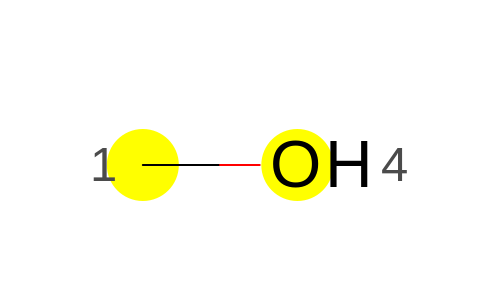

TD record: 2703047 , nonbonded energy diff: -1.9850590757775023e-05 kcal/mol , approx. MM barrier: 1.121929314363135 kcal/mol , QM barrier: 1.2737205330179477


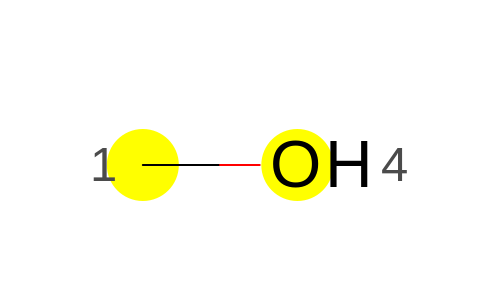

TD record: 2703048 , nonbonded energy diff: -1.9851971895768383e-05 kcal/mol , approx. MM barrier: 1.1219800852832709 kcal/mol , QM barrier: 1.2737210907235148


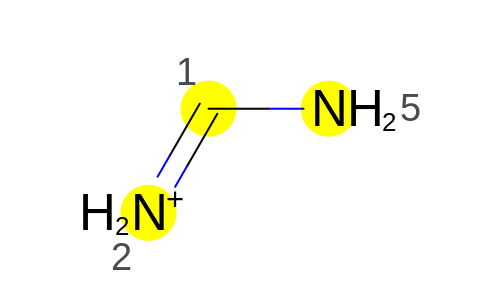

TD record: 2703070 , nonbonded energy diff: 0.0014683773636916253 kcal/mol , approx. MM barrier: 22.05368455602466 kcal/mol , QM barrier: 18.531754637584083


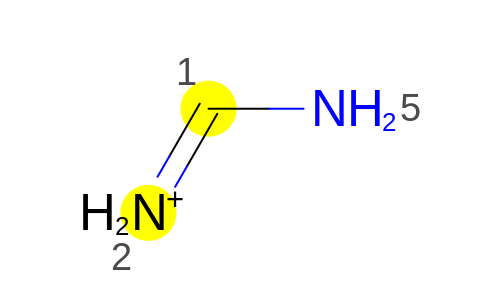

TD record: 2703072 , nonbonded energy diff: -0.0009461857980251481 kcal/mol , approx. MM barrier: 21.479014794389805 kcal/mol , QM barrier: 18.807472842038177


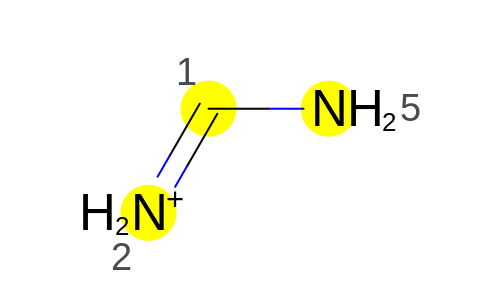

TD record: 2703074 , nonbonded energy diff: 0.0014683716159148014 kcal/mol , approx. MM barrier: 8.345570247243304 kcal/mol , QM barrier: 18.531754577373533


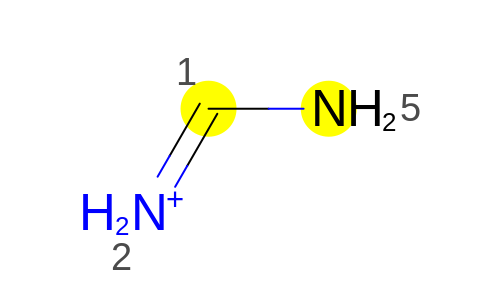

TD record: 2703075 , nonbonded energy diff: -0.0009457940687144506 kcal/mol , approx. MM barrier: 7.767899950190502 kcal/mol , QM barrier: 18.80748251123537


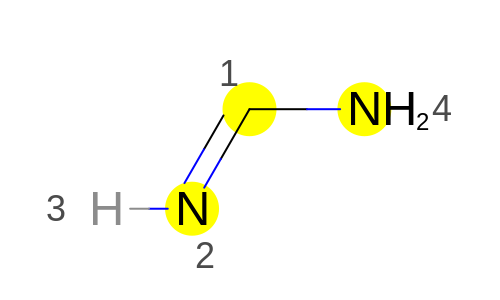

TD record: 2703076 , nonbonded energy diff: 0.004902309548590111 kcal/mol , approx. MM barrier: 7.00447815865102 kcal/mol , QM barrier: 8.141130936551614


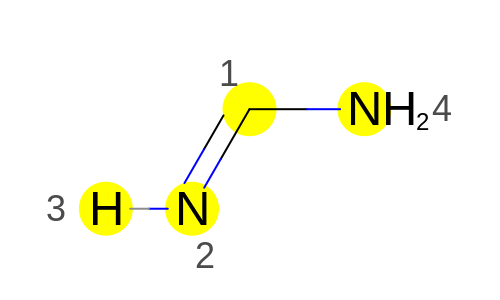

TD record: 2703077 , nonbonded energy diff: 0.006051997101018183 kcal/mol , approx. MM barrier: 66.78067983086083 kcal/mol , QM barrier: 25.78350822584056


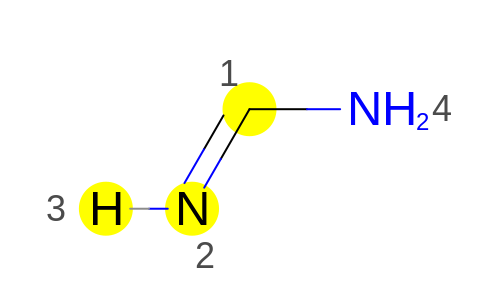

TD record: 2703078 , nonbonded energy diff: 0.005925226197355492 kcal/mol , approx. MM barrier: 60.612598104700254 kcal/mol , QM barrier: 25.89212307621934


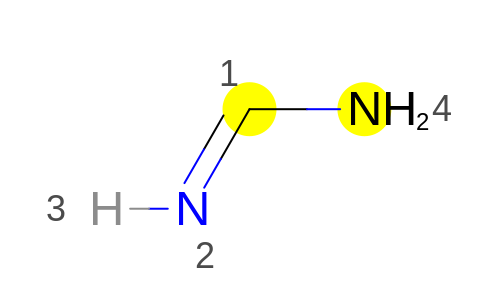

TD record: 2703079 , nonbonded energy diff: 0.003567900223513658 kcal/mol , approx. MM barrier: 6.554573725846847 kcal/mol , QM barrier: 8.196716620394712


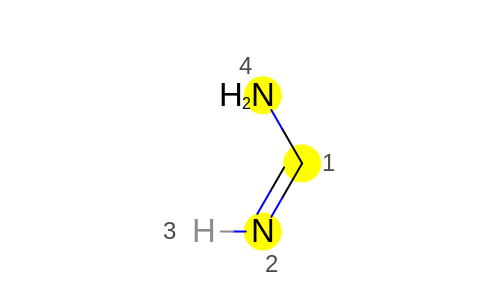

TD record: 2703080 , nonbonded energy diff: 0.0026277269499219227 kcal/mol , approx. MM barrier: 9.440178828105836 kcal/mol , QM barrier: 6.978680149105025


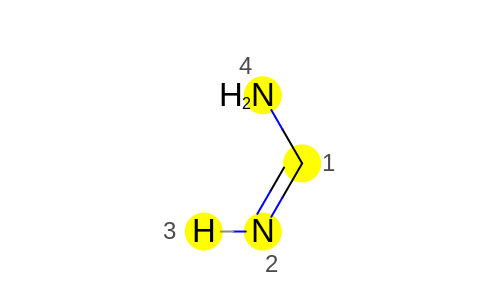

TD record: 2703081 , nonbonded energy diff: 0.006065071500417393 kcal/mol , approx. MM barrier: 66.87017439713938 kcal/mol , QM barrier: 25.783543070110138


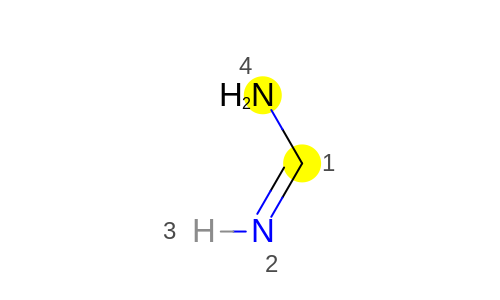

TD record: 2703083 , nonbonded energy diff: 0.002162704221746359 kcal/mol , approx. MM barrier: 9.137037991400723 kcal/mol , QM barrier: 7.039993609891664


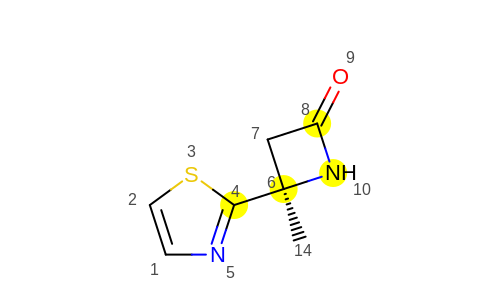

TD record: 2703153 , nonbonded energy diff: 14.822339845472449 kcal/mol , approx. MM barrier: 91.90603570385066 kcal/mol , QM barrier: 47.67038140058971


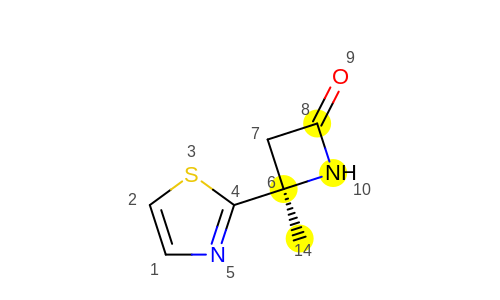

TD record: 2703160 , nonbonded energy diff: 8.83877388333358 kcal/mol , approx. MM barrier: 88.34963563395995 kcal/mol , QM barrier: 45.68339547096329


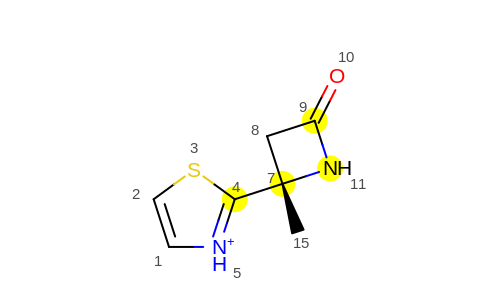

TD record: 2703187 , nonbonded energy diff: 13.073564411029027 kcal/mol , approx. MM barrier: 94.1386412231403 kcal/mol , QM barrier: 51.05250488368475


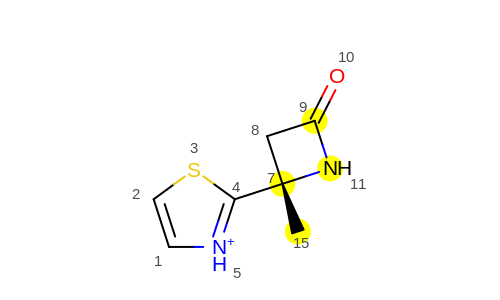

TD record: 2703193 , nonbonded energy diff: 8.532891024474745 kcal/mol , approx. MM barrier: 90.71764108111988 kcal/mol , QM barrier: 46.29798911756324


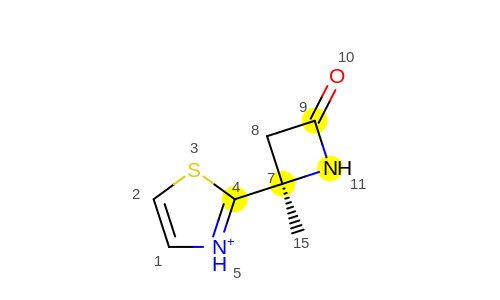

TD record: 2703207 , nonbonded energy diff: 13.073995604579546 kcal/mol , approx. MM barrier: 94.50005847193881 kcal/mol , QM barrier: 51.052348709717904


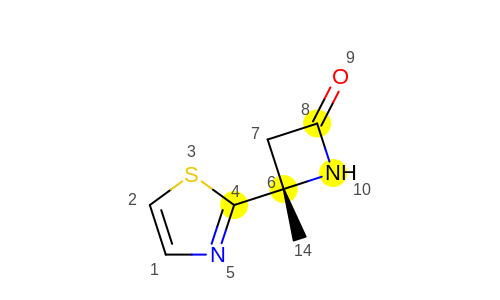

TD record: 2703215 , nonbonded energy diff: 14.819678395367855 kcal/mol , approx. MM barrier: 91.36971570068292 kcal/mol , QM barrier: 47.671229437289604


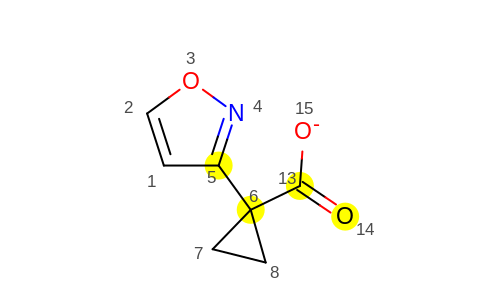

TD record: 2703233 , nonbonded energy diff: -8.073510310654926 kcal/mol , approx. MM barrier: 0.2595504917297262 kcal/mol , QM barrier: 5.341625861157694


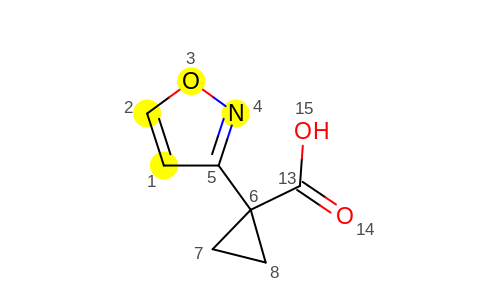

TD record: 2703238 , nonbonded energy diff: -0.006586904888913558 kcal/mol , approx. MM barrier: 22.805720175125018 kcal/mol , QM barrier: 33.83109912537752


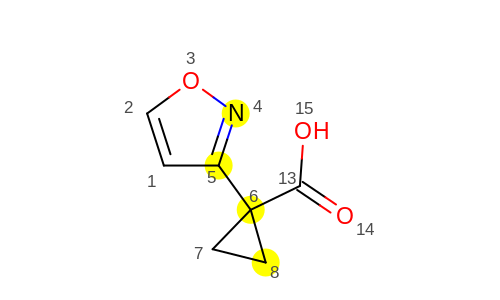

TD record: 2703248 , nonbonded energy diff: 0.008756262864915154 kcal/mol , approx. MM barrier: -0.8797876706398 kcal/mol , QM barrier: 4.640043518701347


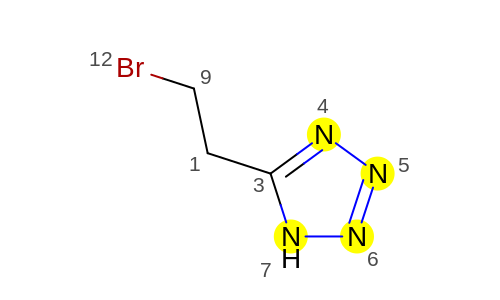

TD record: 2703283 , nonbonded energy diff: -0.004586776417092542 kcal/mol , approx. MM barrier: 22.338655184229708 kcal/mol , QM barrier: 44.08944019188135


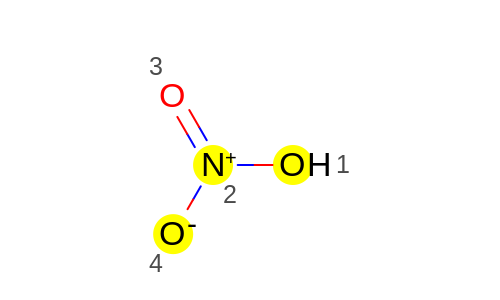

TD record: 2703285 , nonbonded energy diff: 0.0005741570934063905 kcal/mol , approx. MM barrier: 0.5577294667946688 kcal/mol , QM barrier: 8.416937828719858


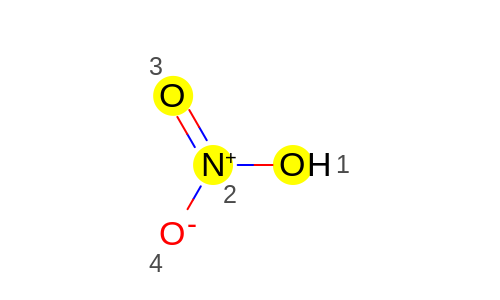

TD record: 2703286 , nonbonded energy diff: 0.0005742452751349371 kcal/mol , approx. MM barrier: 0.5556219979909045 kcal/mol , QM barrier: 8.416919255334747


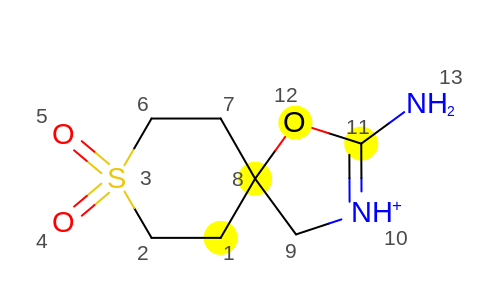

TD record: 2703376 , nonbonded energy diff: 13.350257116312944 kcal/mol , approx. MM barrier: 42.81040196968941 kcal/mol , QM barrier: 50.03626163789865


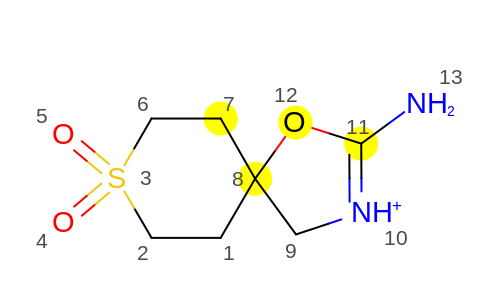

TD record: 2703377 , nonbonded energy diff: 13.355626779549517 kcal/mol , approx. MM barrier: 42.8890469711139 kcal/mol , QM barrier: 50.036641758798524


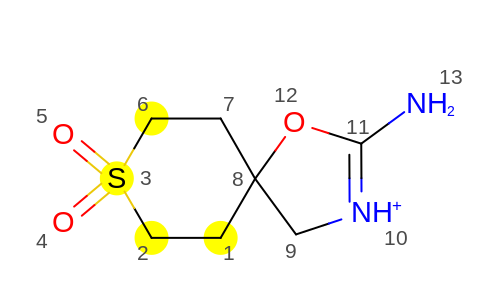

TD record: 2703379 , nonbonded energy diff: 27.760419374408297 kcal/mol , approx. MM barrier: 73.0216123335332 kcal/mol , QM barrier: 52.647689794454834


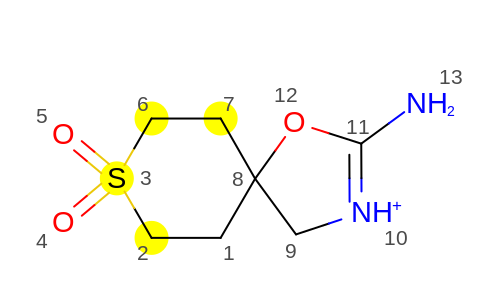

TD record: 2703380 , nonbonded energy diff: 27.786245316800958 kcal/mol , approx. MM barrier: 73.10539138080105 kcal/mol , QM barrier: 52.65000911303297


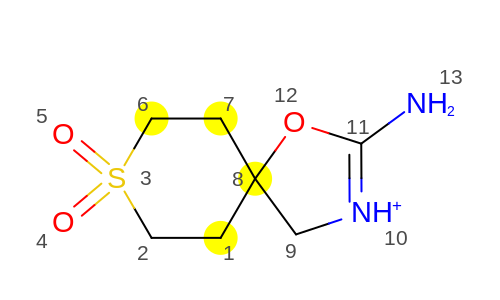

TD record: 2703381 , nonbonded energy diff: 16.25011617670606 kcal/mol , approx. MM barrier: 49.6100219400294 kcal/mol , QM barrier: 35.13889824302058


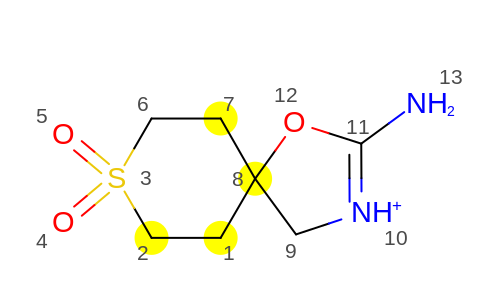

TD record: 2703382 , nonbonded energy diff: 15.735310515948465 kcal/mol , approx. MM barrier: 48.815483735494155 kcal/mol , QM barrier: 34.609573696242016


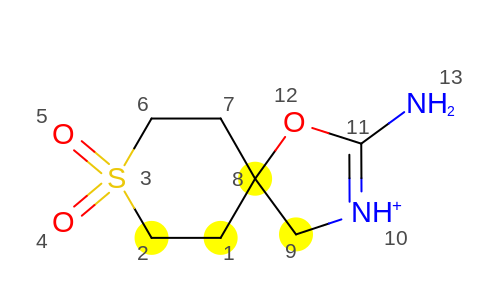

TD record: 2703383 , nonbonded energy diff: 20.46516071836649 kcal/mol , approx. MM barrier: 71.7002521462076 kcal/mol , QM barrier: 41.64030457411349


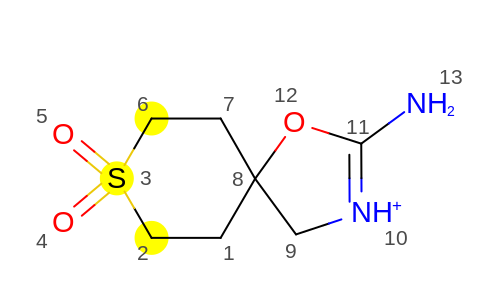

TD record: 2703384 , nonbonded energy diff: 26.2177724080478 kcal/mol , approx. MM barrier: 63.777783496804346 kcal/mol , QM barrier: 42.92368125466929


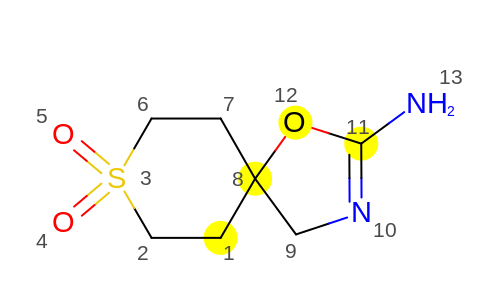

TD record: 2703389 , nonbonded energy diff: 19.110966749159992 kcal/mol , approx. MM barrier: 44.59059113880667 kcal/mol , QM barrier: 52.65363555684493


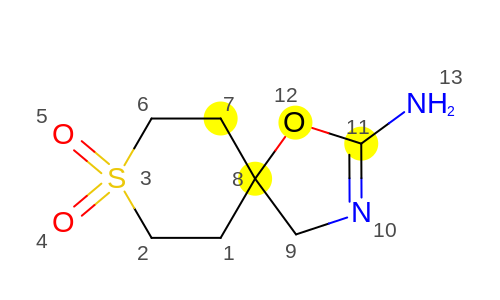

TD record: 2703390 , nonbonded energy diff: 19.109719157239052 kcal/mol , approx. MM barrier: 44.6239376470882 kcal/mol , QM barrier: 52.65108810406099


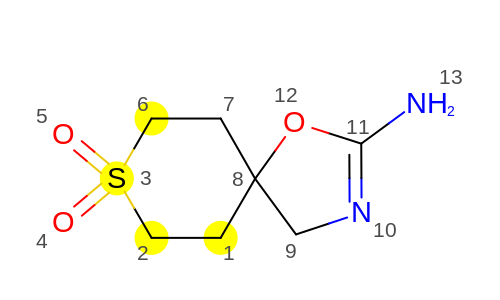

TD record: 2703391 , nonbonded energy diff: 12.151597811848296 kcal/mol , approx. MM barrier: 39.78161702572186 kcal/mol , QM barrier: 38.84592932150169


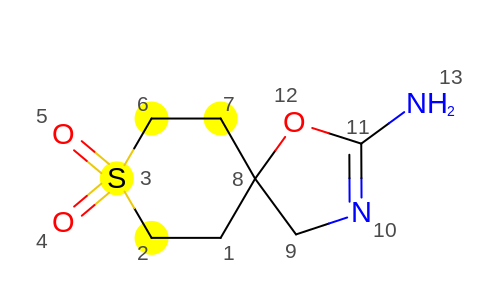

TD record: 2703392 , nonbonded energy diff: 11.943861306478613 kcal/mol , approx. MM barrier: 39.76571825341077 kcal/mol , QM barrier: 38.99863808303283


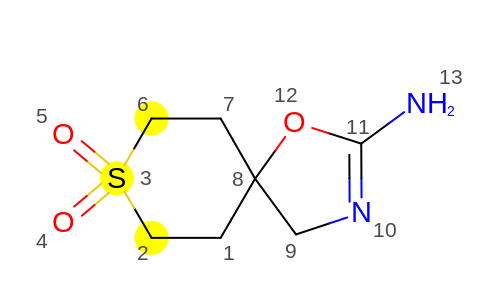

TD record: 2703393 , nonbonded energy diff: 12.960508526517213 kcal/mol , approx. MM barrier: 46.73978059467623 kcal/mol , QM barrier: 42.75017904218911


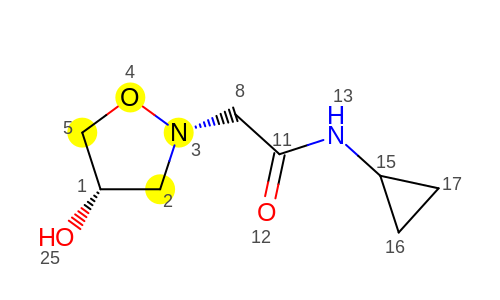

TD record: 2703472 , nonbonded energy diff: 8.045109945836233 kcal/mol , approx. MM barrier: 59.51951590511209 kcal/mol , QM barrier: 52.92677668840244


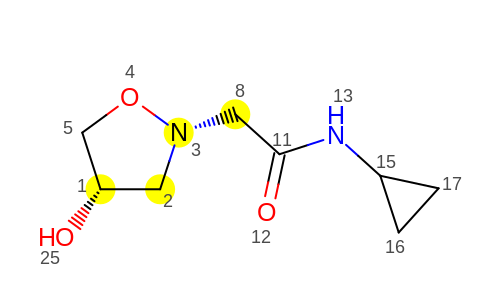

TD record: 2703474 , nonbonded energy diff: 10.27516029842987 kcal/mol , approx. MM barrier: 70.58443390258458 kcal/mol , QM barrier: 45.10740236475184


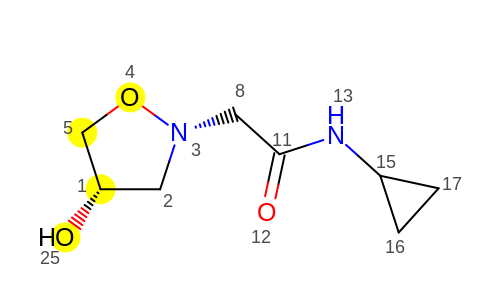

TD record: 2703476 , nonbonded energy diff: 11.900405323788586 kcal/mol , approx. MM barrier: 43.707615961403256 kcal/mol , QM barrier: 44.044186221385765


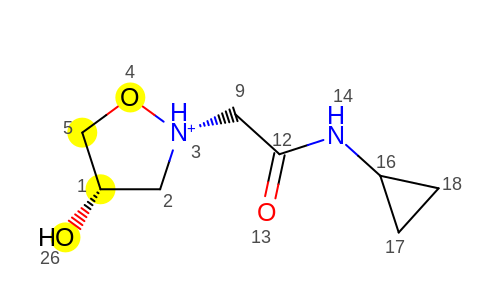

TD record: 2703479 , nonbonded energy diff: 10.949104703644004 kcal/mol , approx. MM barrier: 47.61497181906282 kcal/mol , QM barrier: 39.35596301518719


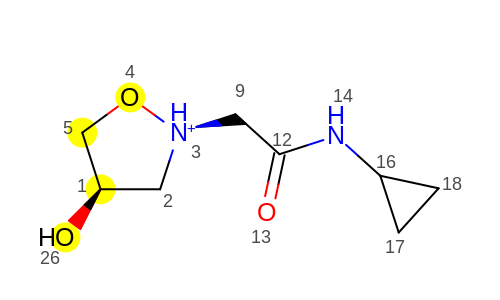

TD record: 2703480 , nonbonded energy diff: 10.946632760251765 kcal/mol , approx. MM barrier: 47.5993163940396 kcal/mol , QM barrier: 39.355432951470306


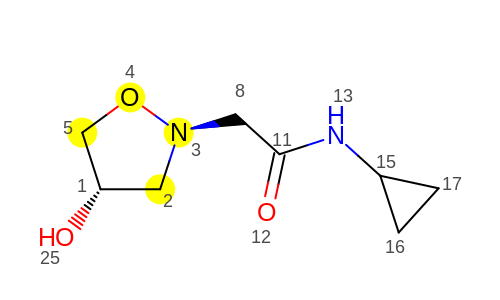

TD record: 2703481 , nonbonded energy diff: 8.886680511911008 kcal/mol , approx. MM barrier: 58.82472169698182 kcal/mol , QM barrier: 53.2257434356573


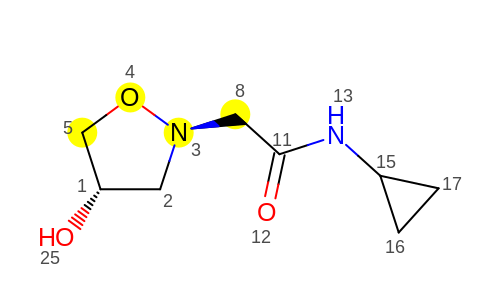

TD record: 2703482 , nonbonded energy diff: 16.476736682108122 kcal/mol , approx. MM barrier: 58.06344776135018 kcal/mol , QM barrier: 46.50217210352938


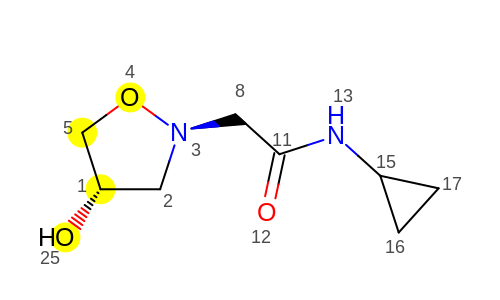

TD record: 2703484 , nonbonded energy diff: 11.736037734164043 kcal/mol , approx. MM barrier: 45.40003698816232 kcal/mol , QM barrier: 43.97030918927665


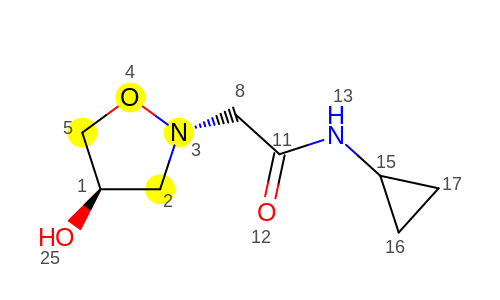

TD record: 2703485 , nonbonded energy diff: 8.900866911157598 kcal/mol , approx. MM barrier: 58.84054675629176 kcal/mol , QM barrier: 53.227138768989725


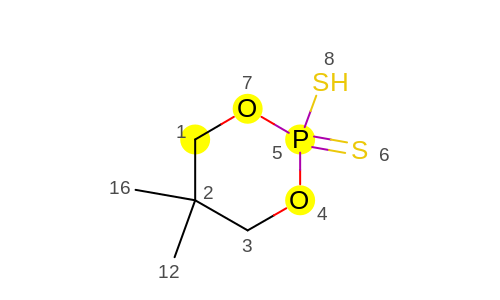

TD record: 2703552 , nonbonded energy diff: 11.321743222997224 kcal/mol , approx. MM barrier: 70.70320661573899 kcal/mol , QM barrier: 52.31343703286702


In [12]:
import qcportal as ptl
client = ptl.FractalClient()

TD_datasets = [
#     'Fragment Stability Benchmark',
# #  'Fragmenter paper',
# #  'OpenFF DANCE 1 eMolecules t142 v1.0',
# #  'OpenFF Fragmenter Validation 1.0',
# #  'OpenFF Full TorsionDrive Benchmark 1',
#  'OpenFF Gen 2 Torsion Set 1 Roche 2',
#  'OpenFF Gen 2 Torsion Set 2 Coverage 2',
#  'OpenFF Gen 2 Torsion Set 3 Pfizer Discrepancy 2',
#  'OpenFF Gen 2 Torsion Set 4 eMolecules Discrepancy 2',
#  'OpenFF Gen 2 Torsion Set 5 Bayer 2',
#  'OpenFF Gen 2 Torsion Set 6 Supplemental 2',
#  'OpenFF Group1 Torsions',
#  'OpenFF Group1 Torsions 2',
#  'OpenFF Group1 Torsions 3',
# #  'OpenFF Primary Benchmark 1 Torsion Set',
# #  'OpenFF Primary Benchmark 2 Torsion Set',
# #  'OpenFF Primary TorsionDrive Benchmark 1',
#  'OpenFF Rowley Biaryl v1.0',
#  'OpenFF Substituted Phenyl Set 1',
#  'OpenFF-benchmark-ligand-fragments-v1.0',
#  'Pfizer Discrepancy Torsion Dataset 1',
 'SMIRNOFF Coverage Torsion Set 1',
#  'SiliconTX Torsion Benchmark Set 1',
#  'TorsionDrive Paper'
              ]

err_td = []
for dataset in TD_datasets:
    print(dataset)
    ds = client.get_collection("TorsionDriveDataset", dataset)
    ds.status("default", status="COMPLETE")
    benchmark_smiles="lim_mobley_parsley_benchmark.smi"
    with open(benchmark_smiles) as f:
        bm_smiles = f.readlines()
    bm_mols = [Molecule.from_smiles(smiles) for smiles in bm_smiles]
    ff = ForceField('openff_unconstrained-1.3.0.offxml')
    qca_entries = []
    for i in range(ds.df.size):
        if ds.df.iloc[i, 0].status == "COMPLETE":
            smiles = ds.df.index[i]
            mapped_smiles = ds.get_entry(smiles).attributes[
                "canonical_isomeric_explicit_hydrogen_mapped_smiles"
            ]
            mol1 = Molecule.from_mapped_smiles(mapped_smiles)
            not_identical = True
            overlaps = 0
            for mol in bm_mols:
                isomorphic,atom_map = Molecule.are_isomorphic(mol1, 
                                                  mol,
                                                  return_atom_map=False,
                                                  aromatic_matching=False,
                                                  formal_charge_matching=False,
                                                  bond_order_matching=False,
                                                  atom_stereochemistry_matching=False,
                                                  bond_stereochemistry_matching=False,
                                                          )
                if(isomorphic):
                    not_identical = False
                    overlaps += 1
                    entry = ds.get_entry(smiles)
                    tdr_id = entry.object_map['default']
                    qca_entries.append(tdr_id)
                    break
            if(not_identical): 
                td = ds.df.iloc[i, 0]
                energies_dict = td.get_final_energies()
                max_idx = max(energies_dict, key=energies_dict.get)
                min_idx = min(energies_dict, key=energies_dict.get)
    #             print(max_idx, min_idx)
                mol = Molecule.from_qcschema(ds.get_entry(smiles))
                mol.partial_charges = np.zeros(mol.n_atoms) * unit.elementary_charge
                try:
                    mol_dict = td.get_final_molecules()
                    min_positions = mol_dict[min_idx].geometry * unit.bohr
                    max_positions = mol_dict[max_idx].geometry * unit.bohr
                    topology = mol.to_topology()
                    try: 
                        system = ff.create_openmm_system(topology, charge_from_molecules=[mol], allow_nonintegral_charges=True)
                        pass
                    except:
                        err_td.append(td.id)
                        continue
                    nonbonded_energy_min_pos = get_energy(system, min_positions, {11})
                    nonbonded_energy_max_pos = get_energy(system, max_positions, {11})
                    total_energy_min_pos = get_energy(system, min_positions, {0,11})
                    total_energy_max_pos = get_energy(system, max_positions, {0,11})
                    nonbonded_energy_diff = nonbonded_energy_max_pos - nonbonded_energy_min_pos
                    total_energy_diff = total_energy_max_pos - total_energy_min_pos
                    qm_energy_diff = 627.509 *(energies_dict[max_idx] - energies_dict[min_idx])
        #             print(type(nonbonded_energy_diff.value_in_unit(unit.kilocalorie_per_mole)))
                    if(abs(nonbonded_energy_diff.value_in_unit(unit.kilocalorie_per_mole)) > 8 or abs(nonbonded_energy_diff.value_in_unit(unit.kilocalorie_per_mole)) < 0.01):
                        display(show_id(td.id))
                        print("TD record:", td.id, ", nonbonded energy diff:", nonbonded_energy_diff, ", approx. MM barrier:", total_energy_diff, ", QM barrier:", qm_energy_diff)
                    pass
                except:
                    continue

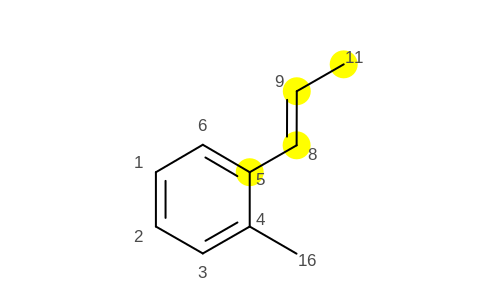

In [30]:
show_id(1803891)